<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/thermodynamics/MEG_injection_and_evaporation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install neqsim

# Crate the fluids
In the following script we create the gas fluid based on analysis from 5th stage separator. And a pure MEG stream.

In [ ]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator

# Start by creating a fluid in neqsim
feedGas = fluid("cpa")  # create a fluid using the SRK-Eo
feedGas.addComponent("nitrogen", 1.016)
feedGas.addComponent("CO2", 1.2297)
feedGas.addComponent("methane", 87.8288)
feedGas.addComponent("ethane", 7.0423)
feedGas.addComponent("propane", 1.9432)
feedGas.addComponent("i-butane", 0.3794)
feedGas.addComponent("n-butane", 0.1942)
feedGas.addComponent("n-pentane", 0.0251)
feedGas.addComponent("i-pentane", 0.0819)
feedGas.addComponent("n-hexane", 0.0061)
feedGas.addComponent("water", 0.0)
feedGas.addComponent("MEG", 0.0)
feedGas.setMixingRule(10)
feedGas.setMultiPhaseCheck(True)

megfluid = feedGas.clone()
megfluid.setMolarComposition([
    0.0,  # nitrogen
    0.0,  # CO2
    0.0,  # methane
    0.0,  # ethane
    0.0,  # propane
    0.0,  # i-butane
    0.0,  # n-butane
    0.0,  # n-pentane
    0.0,  # i-pentane
    0.0,  # n-hexane
    0.0,  # water
    1.0   # MEG
])

# Run a single simulation og wt% MEG/water in gas lift
This code simulates a process where natural gas (feedGas) is mixed with Monoethylene Glycol (MEG) (megfluid) and evaluates wt% MEG in aqueous phase.

In [ ]:
gas_rate = 100000.0 #Sm3/day
MEG_rate = 5 #kg/hr

temperature_grane_5th_stage = 28.0 #C
pressure_grane_5th_stage = 85 #bara

temperature_gas_lift = 40.0 #C
pressire_gas_lift = 130.0 #bara

clearProcess()

dryFeedGas = stream('stream 1', feedGas)
dryFeedGas.setTemperature(temperature_grane_5th_stage, 'C')
dryFeedGas.setPressure(pressure_grane_5th_stage, 'bara')
dryFeedGas.run()

saturatedFeedGas = saturator('water saturator', dryFeedGas)
saturatedFeedGas.run()

feedgas = stream('saturated feed gas', saturatedFeedGas.getOutStream())
feedgas.setFlowRate(gas_rate, 'Sm3/day')
feedgas.run()

megstream = stream('megfluid 1', megfluid)
megstream.setFlowRate(MEG_rate, 'kg/hr')
megstream.setTemperature(temperature_grane_5th_stage, 'C')
megstream.setPressure(pressure_grane_5th_stage, 'bara')
megstream.run()


mixer11 = mixer('mix1')
mixer11.addStream(feedgas)
mixer11.addStream(megstream)
mixer11.run()

heater1 = heater('heater1', mixer11.getOutStream())
heater1.setOutTemperature(temperature_gas_lift, 'C')
heater1.setOutPressure(pressire_gas_lift, 'bara')
heater1.run()

if heater1.getOutStream().getFluid().hasPhaseType('aqueous'):
  wt_water= heater1.getOutStream().getFluid().getPhase('aqueous').getWtFrac('water')*100
  wt_MEG = heater1.getOutStream().getFluid().getPhase('aqueous').getWtFrac('MEG')*100
else:
  wt_water = None
  wt_MEG = None

print('wt% water', wt_water)
print('wt% MEG', wt_MEG)
printFrame(heater1.getOutStream().getFluid())

wt% water 15.738821481888202
wt% MEG 83.77384722454926
| 0                    | 1          | 2                    | 3                    | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:---------------------|:----|:----|:----------------|
|                      | total      | GAS                  | AQUEOUS              |     |     |                 |
| nitrogen             | 1.0175E-2  | 1.01825E-2           | 5.47172E-5           |     |     | [mole fraction] |
| CO2                  | 1.23151E-2 | 1.23234E-2           | 1.16005E-3           |     |     | [mole fraction] |
| methane              | 8.79581E-1 | 8.80228E-1           | 7.45948E-3           |     |     | [mole fraction] |
| ethane               | 7.05267E-2 | 7.05784E-2           | 8.46527E-4           |     |     | [mole fraction] |
| propane              | 1.94606E-2 | 1.94749E-2           | 2.07175E-4           |     |     | [mole fraction] |
| i-butane             | 3.79959E

# Simulate at various pressures and temperatures
This code simulates wt% MEG in aqueous phase for a range of temperatures and pressures, and then visualizes these results using a contour plot, providing insights into how temperature and pressure influence MEG concentration.

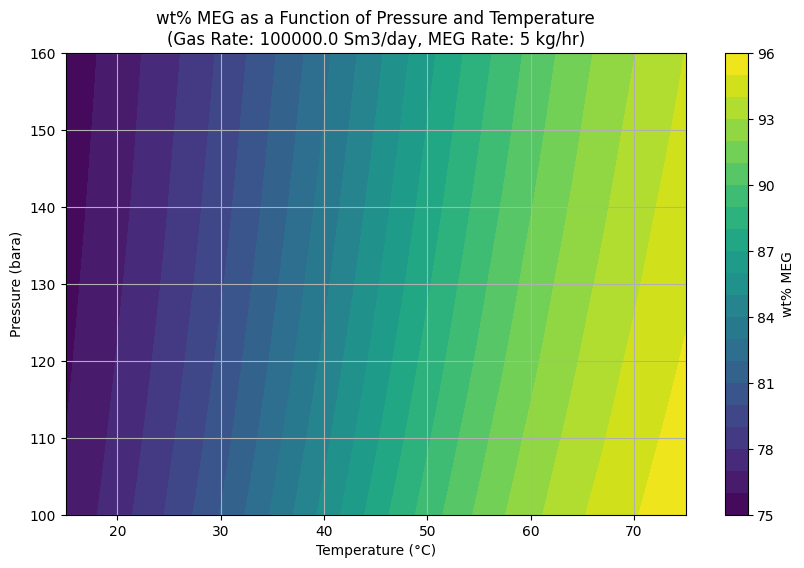

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the pressure and temperature ranges
pressures = np.linspace(100, 160, 20)  # 20 points between 100 and 160 bara
temperatures = np.linspace(15, 75, 20) # 20 points between 15 and 75 °C

# Create empty lists to store the results
MEG_wt_percentages = []

# Iterate over the pressure and temperature ranges
for pressure in pressures:
    for temperature in temperatures:
        # Update the heater conditions
        heater1.setOutTemperature(temperature, 'C')
        heater1.setOutPressure(pressure, 'bara')
        heater1.run()

        # Check if an aqueous phase exists and calculate wt% MEG
        if heater1.getOutStream().getFluid().hasPhaseType('aqueous'):
            MEG_wt_percentage = heater1.getOutStream().getFluid().getPhase('aqueous').getWtFrac('MEG') * 100
        else:
            MEG_wt_percentage = np.nan  # Use NaN if no aqueous phase

        MEG_wt_percentages.append(MEG_wt_percentage)

# Reshape the results into a 2D array for plotting
MEG_wt_percentages = np.array(MEG_wt_percentages).reshape(len(pressures), len(temperatures))

# Create the plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(temperatures, pressures, MEG_wt_percentages, levels=20)
plt.colorbar(contour, label='wt% MEG')
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (bara)')
plt.title(f'wt% MEG as a Function of Pressure and Temperature\n(Gas Rate: {gas_rate} Sm3/day, MEG Rate: {MEG_rate} kg/hr)')
plt.grid(True)
plt.show()